In [1]:
# Data manipulation
# ==============================================================================
import warnings
import shap
import math
from skforecast.utils import load_forecaster
from skforecast.utils import save_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import grid_search_forecaster
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoreg import ForecasterAutoreg
import skforecast
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
import numpy as np
import pandas as pd
from skforecast.datasets import fetch_dataset
from IAT_dataparser import IATDataParser

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10

# Modeling and Forecasting
# ==============================================================================


# Warnings configuration
# ==============================================================================
warnings.filterwarnings('once')

print('Skforecast version: ', skforecast.__version__)

Skforecast version:  0.12.1


In [2]:
data_path = "../data/pcap/MIRAGE-COVID-CCMA-2022/Raw_JSON/Teams/1619005750_com.microsoft.teams_mirage2020dataset_labeled_biflows_all_packets_encryption_metadata.json"
# data_path = '../data/pcap/MIRAGE-COVID-CCMA-2022/Raw_JSON/Teams/1619782605_com.microsoft.teams_mirage2020dataset_labeled_biflows_all_packets_encryption_metadata.json'
# data_path = "../data/pcap/MIRAGE-COVID-CCMA-2022/Raw_JSON/Teams/1619192105_com.microsoft.teams_mirage2020dataset_labeled_biflows_all_packets_encryption_metadata.json"

# Instantiate DataParser class
iat_data_parser = IATDataParser(data_path)

# Reading the biflow data
biflow_data = iat_data_parser.biflow_data

biflows = list(biflow_data.keys())

print("biflows: ", biflows)
print('number of biflows: ', len(biflows))

biflows:  ['192.168.20.111,68,192.168.20.254,67,17', '192.168.20.111,51560,8.8.4.4,853,6', '192.168.20.111,46279,8.8.8.8,853,6', '192.168.20.111,55009,142.250.180.68,443,6', '192.168.20.111,55586,142.250.184.35,80,6', '192.168.20.111,51564,8.8.4.4,853,6', '192.168.20.111,40978,108.177.127.188,5228,6', '192.168.20.111,38155,142.250.184.36,443,17', '192.168.20.111,38544,142.250.184.36,443,6', '192.168.20.111,39646,172.217.21.67,443,6', '192.168.20.111,33755,142.250.184.42,443,6', '192.168.20.111,32786,216.58.205.74,443,6', '192.168.20.111,41662,216.58.206.42,443,6', '192.168.20.111,41663,216.58.206.42,443,6', '192.168.20.111,41513,216.58.198.46,443,6', '192.168.20.111,41515,216.58.198.46,443,6', '192.168.20.111,37742,142.250.180.74,443,17', '192.168.20.111,57411,142.250.180.74,443,17', '192.168.20.111,36736,142.250.180.74,443,6', '192.168.20.111,36737,142.250.180.74,443,6', '192.168.20.111,51073,216.58.198.42,443,17', '192.168.20.111,58540,216.58.198.42,443,6', '192.168.20.111,50145,216.

In [3]:
test_IAT = iat_data_parser.generate_debug_set()
test_IAT = iat_data_parser.saturate_99(test_IAT)
test_IAT = iat_data_parser.minmax_scaler(test_IAT)

test_IAT = test_IAT.iloc[900:]
# len(test_IAT)
test_IAT

,Interarrival,Interarrival_scaled
900,0.018991,0.172103
901,0.020988,0.190201
902,0.019988,0.181138
903,0.019991,0.181166
904,0.022989,0.208335
...,...,...
1309,0.012995,0.117765
1310,0.023989,0.217397
1311,0.015990,0.144907
1312,0.110347,1.000000


Steps:  82
Train dates : 900 --- 1231  (n=332)
Test dates  : 1232 --- 1313  (n=82)


/home/ce-intern/Desktop/network_time_prediction/network-pred/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


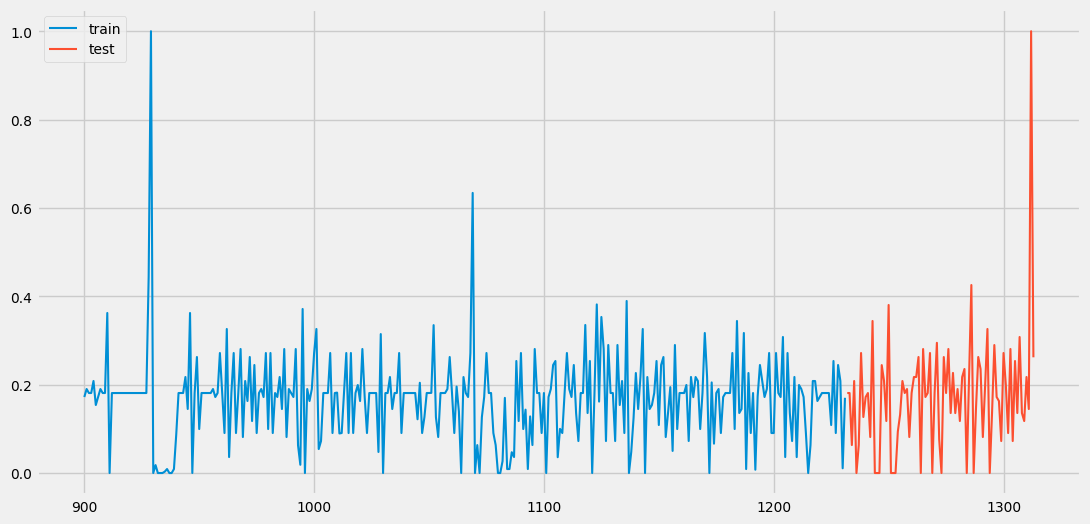

In [4]:
# Split data into train-test
# ==============================================================================
steps = len(test_IAT) * 0.2  # 80/20 split
steps = math.floor(steps)
print("Steps: ", steps)

data_train = test_IAT[:-steps]
data_test = test_IAT[-steps:]
print(
    f"Train dates : {data_train.index.min()} --- "
    f"{data_train.index.max()}  (n={len(data_train)})"
)
print(
    f"Test dates  : {data_test.index.min()} --- "
    f"{data_test.index.max()}  (n={len(data_test)})"
)

fig, ax = plt.subplots(figsize=(12, 6))
data_train['Interarrival_scaled'].plot(ax=ax, label='train')
data_test['Interarrival_scaled'].plot(ax=ax, label='test')
ax.legend()

In [5]:
# A naive approach
# Create and train forecaster
# We look into the past 100 readings and try to predict the next 30
# ==============================================================================
forecaster = ForecasterAutoreg(
    regressor=RandomForestRegressor(random_state=123),
    lags=20
)
forecaster.fit(y=data_train['Interarrival_scaled'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
Transformer for y: None 
Transformer for exog: None 
Window size: 20 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [900, 1231] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2024-05-30 16:46:52 
Last fit date: 2024-05-30 16:46:52 
Skforecast version: 0.12.1 
Pytho

In [6]:
# Predictions
# ==============================================================================
# steps = 80
print("Steps: ", steps)
predictions = forecaster.predict(steps=steps)
predictions.head(5)

Steps:  82


1232    0.164549
1233    0.177297
1234    0.193460
1235    0.151722
1236    0.184963
Name: pred, dtype: float64

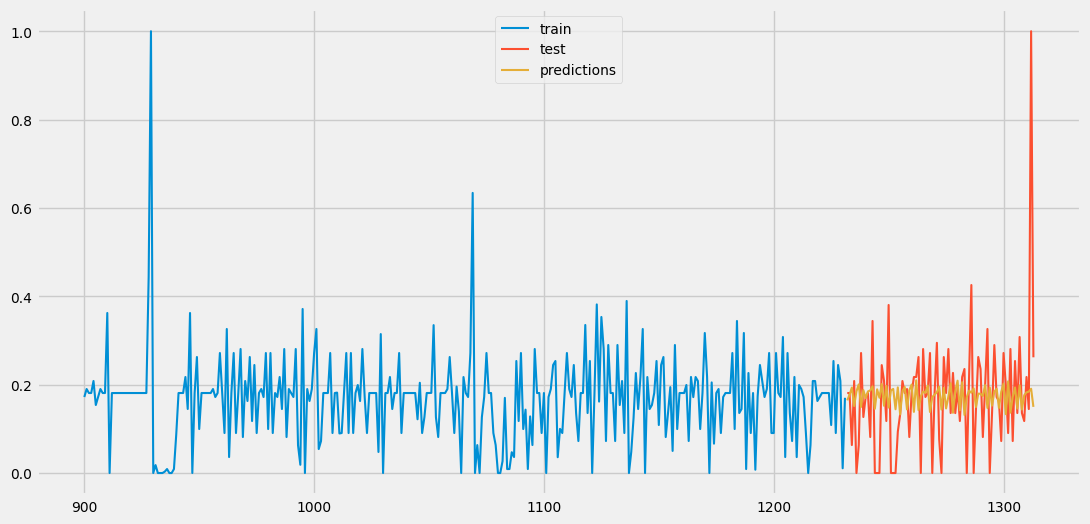

In [7]:
# Plot predictions versus test data
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 6))
data_train['Interarrival_scaled'].plot(ax=ax, label='train')
data_test['Interarrival_scaled'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend()

In [8]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
    y_true=data_test['Interarrival_scaled'],
    y_pred=predictions
)
print(f"Test error (MSE): {error_mse}")

Test error (MSE): 0.019205516280106173


In [9]:
# # Hyperparameters: grid search
# # ==============================================================================
# # steps = 80
# print("Steps: ", steps)
# forecaster = ForecasterAutoreg(
#     regressor=RandomForestRegressor(random_state=123),
#     lags=90  # This value will be replaced in the grid search
# )

# # Candidate values for lags
# lags_grid = [30, 40, 50, 60, 70]

# # Candidate values for regressor's hyperparameters
# param_grid = {
#     'n_estimators': [100, 200, 300, 400, 500],
#     'max_depth': [50, 60, 70, 80, 90, 100],
# }

# results_grid = grid_search_forecaster(
#     forecaster=forecaster,
#     y=data_train['Interarrival_scaled'],
#     param_grid=param_grid,
#     lags_grid=lags_grid,
#     steps=steps,
#     refit=False,
#     metric='mean_squared_error',
#     initial_train_size=int(len(data_train)*0.5),
#     fixed_train_size=False,
#     return_best=True,
#     n_jobs='auto',
#     verbose=False
# )

# # Search results
# # ==============================================================================
# results_grid

In [15]:
# `Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
#   Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
#  25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
#  49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70] 
#   Parameters: {'max_depth': 70, 'n_estimators': 500}
#   Backtesting metric: 0.007899003684954402

# Create and train forecaster with the best hyperparameters and lags found
# ==============================================================================
regressor = RandomForestRegressor(
    n_estimators=200, max_depth=100, random_state=123)
forecaster = ForecasterAutoreg(
    regressor=regressor,
    lags=50
)

forecaster.fit(y=data_train['Interarrival_scaled'])

In [16]:
# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=steps)

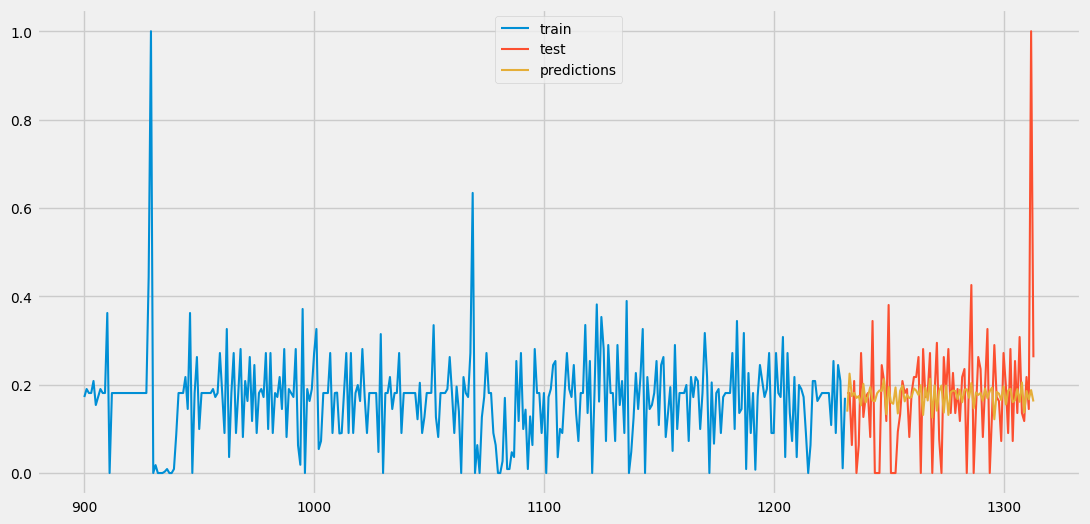

In [17]:
# Plot predictions versus test data
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 6))
data_train['Interarrival_scaled'].plot(ax=ax, label='train')
data_test['Interarrival_scaled'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend()

In [13]:
# Backtesting
# ==============================================================================
# steps = 80
print("Steps: ", steps)
n_backtesting = steps * 3  
metric, predictions_backtest = backtesting_forecaster(
    forecaster=forecaster,
    y=test_IAT['Interarrival_scaled'],
    initial_train_size=len(test_IAT) - n_backtesting,
    fixed_train_size=False,
    steps=steps,
    metric='mean_squared_error',
    refit=True,
    verbose=True,
    show_progress=True
)
print(f"Backtest metric (MSE): {metric}")

Steps:  82
Information of backtesting process
----------------------------------
Number of observations used for initial training: 168
Number of observations used for backtesting: 246
    Number of folds: 3
    Number of steps per fold: 82
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   900 -- 1067  (n=168)
    Validation: 1068 -- 1149  (n=82)
Fold: 1
    Training:   900 -- 1149  (n=250)
    Validation: 1150 -- 1231  (n=82)
Fold: 2
    Training:   900 -- 1231  (n=332)
    Validation: 1232 -- 1313  (n=82)



  0%|          | 0/3 [00:00<?, ?it/s]

Backtest metric (MSE): 0.01304915784124199


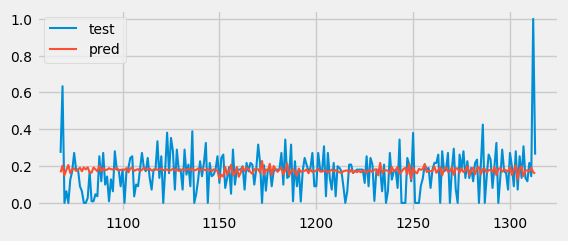

In [14]:
# Plot backtest predictions vs real values
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
test_IAT.loc[predictions_backtest.index,
               'Interarrival_scaled'].plot(ax=ax, label='test')
predictions_backtest.plot(ax=ax, label='predictions')
ax.legend()